In [1]:
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import warnings

from keras_tqdm import TQDMNotebookCallback # Replacement to keras progress bar since, Keras progress bar isn't working properly.

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K

K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_rows = 96
img_cols = 96

smooth = 1.  # Parameter used in defining loss function

Using TensorFlow backend.


In [2]:
def load_train_data(): # Loading train  and test data from numpy array.
    imgs_train = np.load('imgs_train.npy')
    imgs_mask_train = np.load('imgs_mask_train.npy')
    return imgs_train, imgs_mask_train

def load_test_data():
    imgs_test = np.load('imgs_test.npy')
    imgs_id = np.load('imgs_id_test.npy')
    return imgs_test, imgs_id

### Defining Loss Function and Metrics

In [3]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1. / (dice_coef(y_true, y_pred) + smooth)

### Model architecture.

In [4]:
def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [1]:
def preprocess(imgs):  # Preprocessing reducing deminsions.
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), mode='constant', preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

In [10]:
import matplotlib 
from matplotlib import pyplot as plt 
def plot_history(history):  # Ploting history function
    plt.rcParams["figure.figsize"] = [15,5]
    # summarize history for loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss']), plt.plot(history.history['val_loss'])
    plt.title('model loss'), plt.ylabel('loss'), plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right',prop={'size': 12})
    # summarize history for accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['dice_coef']), plt.plot(history.history['val_dice_coef'])
    plt.title(' model Dice Coefficient'), plt.ylabel('Dice Coef'), plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right',prop={'size': 12})
    plt.show()
    print('Train Dice Coef:', history.history['dice_coef'][-1])
    print('Test Dice Coef:', history.history['val_dice_coef'][-1])

In [7]:
def train_and_predict():  # Model training
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask_train = load_train_data()

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization
    print('-'*30)
    print('Stats about training dataset (for future use), Mean: {} Std: {}'.format(mean,std))
    print('-'*30)
    imgs_train -= mean
    imgs_train /= std

    imgs_mask_train = imgs_mask_train.astype('float32')
    imgs_mask_train /= 255.  # scale masks to [0, 1]

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)
    early_s = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    history=model.fit(imgs_train, imgs_mask_train, batch_size=32, epochs=20, verbose=0, shuffle=True,
              validation_split=0.2,
              callbacks=[model_checkpoint,early_s,TQDMNotebookCallback(leave_inner=True)])
    
    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)
    imgs_test, imgs_id_test = load_test_data()   # Predictions.
    imgs_test = preprocess(imgs_test)

    imgs_test = imgs_test.astype('float32')
    imgs_test -= mean
    imgs_test /= std

    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('weights.h5')
    
    print('-'*30)
    print('Saving model...')
    print('-'*30)
    model.save('base_model.h5')
    
    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_mask_test = model.predict(imgs_test, verbose=1)
    np.save('imgs_mask_test.npy', imgs_mask_test)

    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)
    pred_dir = 'preds'
    if not os.path.exists(pred_dir):
        os.mkdir(pred_dir)
    for image, image_id in zip(imgs_mask_test, imgs_id_test):
        image = (image[:, :, 0] * 255.).astype(np.uint8)
        with warnings.catch_warnings():   # To ignore pred.png is a low contrast image from skimage.
            warnings.simplefilter("ignore")
            imsave(os.path.join(pred_dir, str(image_id) + '_pred.png'), image)
    print('-' * 30)
    print('Saving done...')
    print('-' * 30)
    return history

In [8]:
history=train_and_predict()

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Stats about training dataset (for future use), Mean: 99.32807159423828 Std: 56.43379592895508
------------------------------
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.



------------------------------
Saving model...
------------------------------
------------------------------
Loading and preprocessing test data...
------------------------------
------------------------------
Loading saved weights...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
5508/5508 [==============================] - 18s    
------------------------------
Saving predicted masks to files...
------------------------------
------------------------------
Saving done...
------------------------------


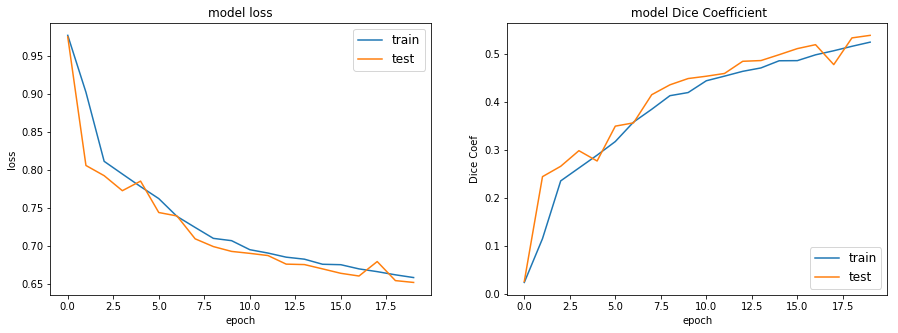

Train Dice Coef: 0.524178249807
Test Dice Coef: 0.538335078563


In [11]:
plot_history(history)